In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, recall_score, make_scorer

%run functions.ipynb

In [2]:
#import data
orig_data = pd.read_csv('../Data/BankChurners.csv')
orig_data.drop(columns=orig_data.columns[-2:], inplace=True)
X_pre = orig_data.iloc[:,2:-1]
X = pd.get_dummies(X_pre, drop_first=True)
y = np.where(orig_data['Attrition_Flag'] == 'Existing Customer', 0, 1).astype(bool)
orig_data.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [3]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [4]:
# Define pipeline
over = SMOTE(random_state=0)
under = RandomUnderSampler(random_state=0)
decision_tree = DecisionTreeClassifier(random_state=0)
steps = [('over', over), 
         ('under', under),
         ('classifier', decision_tree)]
model = Pipeline(steps=steps)

In [5]:
# Define parameter grid
param_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 10, 20, 30, 40, 50],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': [None, 'sqrt', 'log2']}

In [6]:
# Define recall as the scoring metric
recall_scorer = make_scorer(recall_score, average='binary')

In [7]:
print("Tuned Decision Tree test results")

Tuned Decision Tree test results


In [8]:
# Perform the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=recall_scorer, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('over', SMOTE(random_state=0)),
                                       ('under',
                                        RandomUnderSampler(random_state=0)),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=0))]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [None, 10, 20, 30, 40, 50],
                         'classifier__max_features': [None, 'sqrt', 'log2'],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10]},
             scoring=make_scorer(recall_score, average=binary), verbose=2)

In [9]:
# Check the best parameters
print("Best parameters found: ")
print(pd.Series(grid_search.best_params_))

Best parameters found: 
classifier__criterion            entropy
classifier__max_depth                 10
classifier__max_features            None
classifier__min_samples_leaf           4
classifier__min_samples_split         10
dtype: object


In [10]:
# Evaluate the model with the best parameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

In [11]:
# Print classification report
print(classification_report(y_test, y_pred, target_names=['Existing Customer', 'Attrited Customer']))

                   precision    recall  f1-score   support

Existing Customer       0.98      0.95      0.96      2583
Attrited Customer       0.77      0.87      0.81       456

         accuracy                           0.94      3039
        macro avg       0.87      0.91      0.89      3039
     weighted avg       0.94      0.94      0.94      3039



In [12]:
results = pd.DataFrame(zip(y_test, y_pred_prob), columns=['actual','confidence'])
results_df = pd.DataFrame()

for prob in range(0,65,5):
    col_name = "threshold_" + str(prob)
    results[prob] = results['confidence'] > (prob/100)
    cm = confusion_matrix_class(confusion_matrix(results['actual'], results[prob]),inverse=True)
    #add record to test results df
    new_record = create_results_record(label=col_name,  
                                       cm=cm)
    results_df = pd.concat([results_df, pd.DataFrame([new_record])], ignore_index=True).drop_duplicates()
    
print(results_df.to_string())

           label  accuracy  precision  recall     F1   tp   fp  fn    tn  pred_pos  pred_neg  act_pos  act_neg  total
0    threshold_0     0.872      0.542   0.941  0.688  429  362  27  2221       791      2248      456     2583   3039
1    threshold_5     0.887      0.577   0.936  0.714  427  313  29  2270       740      2299      456     2583   3039
2   threshold_10     0.895      0.597   0.925  0.726  422  285  34  2298       707      2332      456     2583   3039
3   threshold_15     0.895      0.598   0.921  0.725  420  282  36  2301       702      2337      456     2583   3039
4   threshold_20     0.904      0.623   0.919  0.742  419  254  37  2329       673      2366      456     2583   3039
5   threshold_25     0.912      0.647   0.917  0.759  418  228  38  2355       646      2393      456     2583   3039
6   threshold_30     0.925      0.691   0.908  0.785  414  185  42  2398       599      2440      456     2583   3039
7   threshold_35     0.934      0.729   0.890  0.802  40

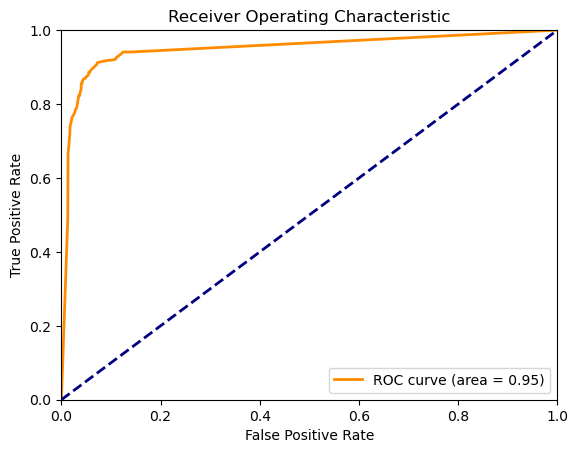

In [13]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

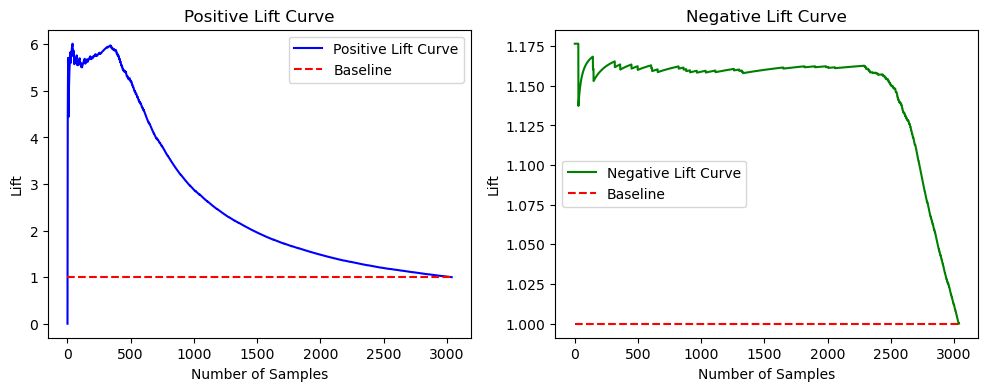

In [14]:
# Plot the lift curves
plot_lift_curves(y_test, y_pred_prob)

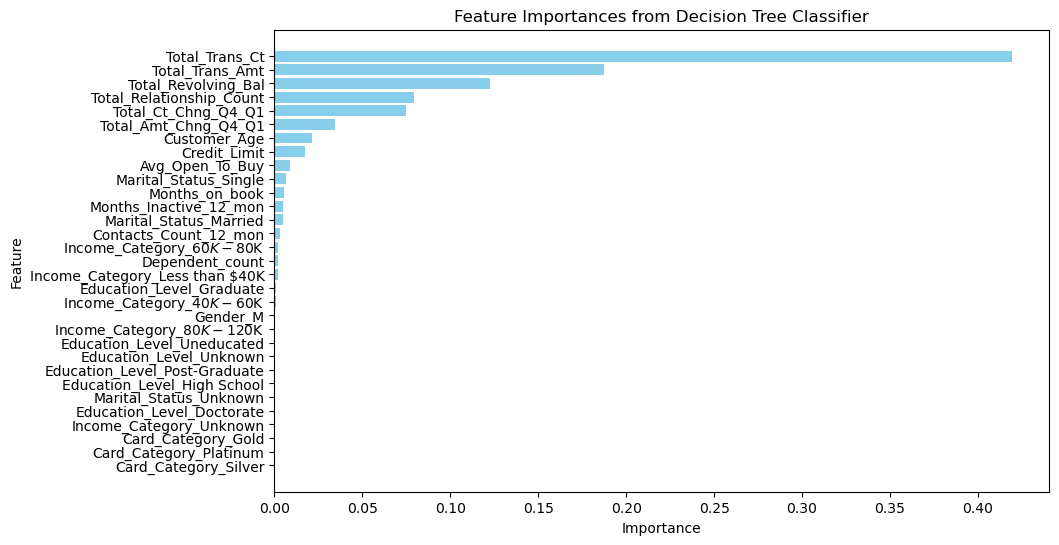

In [15]:
# Get feature importances
classifier = best_model.named_steps['classifier']
feature_importances = classifier.feature_importances_

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['feature'], feature_importances_df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Decision Tree Classifier')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

In [16]:
feature_importances_df

,feature,importance
11,Total_Trans_Ct,0.419514
10,Total_Trans_Amt,0.187672
7,Total_Revolving_Bal,0.122447
3,Total_Relationship_Count,0.079399
12,Total_Ct_Chng_Q4_Q1,0.075061
9,Total_Amt_Chng_Q4_Q1,0.034794
0,Customer_Age,0.021164
6,Credit_Limit,0.017392
8,Avg_Open_To_Buy,0.008824
21,Marital_Status_Single,0.006642
